In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Display settings (show more digits, wider tables)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 180)
pd.set_option("display.float_format", lambda x: f"{x:.15f}") 

# Load dataset
df = pd.read_csv('movies.csv')

## PART 1: DATA EXPLORATION & CLEANING

Task 1.1 — Initial Exploration

In [10]:
# 1.How many movies and columns are in the dataset?

print("Rows, Columns =", df.shape)

# 2.Which columns have missing data, and how much?
missing_count = df.isna().sum().sort_values(ascending=False)
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)

print("Missing (count):")
display(missing_count)

print("Missing (%):")
display(missing_pct)

# 3.What are the data types for each column?
df.info()

Rows, Columns = (3000, 14)
Missing (count):


metascore            422
movie_id               0
title                  0
release_year           0
genre                  0
budget                 0
revenue                0
runtime                0
imdb_rating            0
votes                  0
director               0
main_actor             0
oscar_nominations      0
oscar_wins             0
dtype: int64

Missing (%):


metascore           14.066666666666666
movie_id             0.000000000000000
title                0.000000000000000
release_year         0.000000000000000
genre                0.000000000000000
budget               0.000000000000000
revenue              0.000000000000000
runtime              0.000000000000000
imdb_rating          0.000000000000000
votes                0.000000000000000
director             0.000000000000000
main_actor           0.000000000000000
oscar_nominations    0.000000000000000
oscar_wins           0.000000000000000
dtype: float64

<class 'pandas.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_id           3000 non-null   int64  
 1   title              3000 non-null   str    
 2   release_year       3000 non-null   int64  
 3   genre              3000 non-null   str    
 4   budget             3000 non-null   float64
 5   revenue            3000 non-null   float64
 6   runtime            3000 non-null   int64  
 7   imdb_rating        3000 non-null   float64
 8   metascore          2578 non-null   float64
 9   votes              3000 non-null   float64
 10  director           3000 non-null   str    
 11  main_actor         3000 non-null   str    
 12  oscar_nominations  3000 non-null   int64  
 13  oscar_wins         3000 non-null   int64  
dtypes: float64(5), int64(5), str(4)
memory usage: 328.3 KB


Task 1.2 — Handling Missing Data (metascore)

In [11]:
print("\n--- TASK 1.2: HANDLING MISSING DATA ---")

df_clean = df.copy()

# Strategy: Fill 'metascore' with median value by genre
# Justification: Metascore distributions differ across genres, and median is robust to outliers.
print("Before filling: Metascore missing =", df_clean["metascore"].isna().sum())

df_clean["metascore"] = df_clean.groupby("genre")["metascore"].transform(
    lambda x: x.fillna(x.median())
)

# Fallback: if a genre has ONLY NaNs, fill with global median
df_clean["metascore"] = df_clean["metascore"].fillna(df_clean["metascore"].median())

print("After filling: Metascore missing =", df_clean["metascore"].isna().sum())


--- TASK 1.2: HANDLING MISSING DATA ---
Before filling: Metascore missing = 422
After filling: Metascore missing = 0


Task 1.3 — Data Validation

In [12]:
print("\n--- TASK 1.3: DATA VALIDATION ---")

dfv = df_clean.copy()  # use your cleaned df (after metascore filling)

# 1) Impossible values (basic checks)
invalid_mask = (
    (dfv["budget"] < 0) |
    (dfv["revenue"] < 0) |
    (dfv["runtime"] < 10) |
    (dfv["imdb_rating"] < 0) | (dfv["imdb_rating"] > 10) |
    (dfv["metascore"] < 0) | (dfv["metascore"] > 100) |
    (dfv["votes"] < 0) |
    (dfv["oscar_nominations"] < 0) |
    (dfv["oscar_wins"] < 0)
)

print("Invalid rows (impossible values):", int(invalid_mask.sum()))

# Remove invalid rows (only if there are any)
dfv = dfv[~invalid_mask].copy()
print("Shape after removing invalid rows:", dfv.shape)

# 2) Extreme outliers (IQR method)
def iqr_outliers(s):
    # English: return boolean mask for IQR outliers
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lo = q1 - 1.5 * iqr
    hi = q3 + 1.5 * iqr
    return (s < lo) | (s > hi), lo, hi

outlier_cols = ["budget", "revenue", "votes", "runtime"]
outlier_report = {}

for c in outlier_cols:
    m, lo, hi = iqr_outliers(dfv[c].dropna())
    outlier_report[c] = {"outliers": int(m.sum()), "lo": lo, "hi": hi}

print("\nIQR Outliers summary:")
for k, v in outlier_report.items():
    print(f"{k}: outliers={v['outliers']}, bounds=[{v['lo']}, {v['hi']}]")

# 3) Inconsistent data (revenue < budget) — NOT an error, just unprofitable movies
unprofitable = (dfv["revenue"] < dfv["budget"]).sum()
print("\nMovies with revenue < budget:", int(unprofitable), f"({unprofitable/len(dfv)*100}%)")

# dfv is your validated dataframe for next parts


--- TASK 1.3: DATA VALIDATION ---
Invalid rows (impossible values): 0
Shape after removing invalid rows: (3000, 14)

IQR Outliers summary:
budget: outliers=209, bounds=[-35.18125, 93.06875]
revenue: outliers=245, bounds=[-168.75499999999997, 381.68499999999995]
votes: outliers=255, bounds=[-186.78750000000002, 424.9125]
runtime: outliers=11, bounds=[52.0, 188.0]

Movies with revenue < budget: 129 (4.3%)


PART 2: DESCRIPTIVE STATISTICS

In [13]:
print("\n=== PART 2: DESCRIPTIVE STATISTICS ===")

numeric_cols = [
    "budget","revenue","runtime","imdb_rating",
    "metascore","votes","oscar_nominations","oscar_wins"
]

# --------------------------------------------------
# Task 2.1 — FULL NUMERICAL SUMMARY TABLE
# --------------------------------------------------
def iqr(s):
    return s.quantile(0.75) - s.quantile(0.25)

rows = []
for col in numeric_cols:
    s = dfv[col].dropna()
    mode_val = s.mode().iloc[0] if len(s.mode()) else np.nan

    rows.append({
        "variable": col,
        "mean": s.mean(),
        "median": s.median(),
        "mode": mode_val,
        "range": s.max() - s.min(),
        "variance": s.var(ddof=1),
        "std": s.std(ddof=1),
        "IQR": iqr(s),
        "min": s.min(),
        "Q1": s.quantile(0.25),
        "Q3": s.quantile(0.75),
        "max": s.max()
    })

summary_table = pd.DataFrame(rows).set_index("variable")

print("\n[Task 2.1] Numerical summary table")
display(summary_table)


# --------------------------------------------------
# Task 2.2 — CATEGORICAL SUMMARY (TOP-10 + %)
# --------------------------------------------------
print("\n[Task 2.2] Categorical summary")

for col in ["genre","director","main_actor"]:
    print(f"\nColumn: {col}")
    print("Unique values:", dfv[col].nunique())

    top10 = dfv[col].value_counts().head(10)
    pct10 = (top10 / dfv[col].value_counts().sum()) * 100

    print("Top-10 most frequent values:")
    display(top10.to_frame("count"))

    print("Proportions (%):")
    display(pct10.to_frame("percent"))


# --------------------------------------------------
# Task 2.3 — STATISTICAL INTERPRETATION
# --------------------------------------------------

# 1) Highest variability (Coefficient of Variation)
cv = (summary_table["std"] / summary_table["mean"]).sort_values(ascending=False)

print("\n[Task 2.3 — Q1] Highest coefficient of variation:")
display(cv.to_frame("CV"))


# 2) Skewness approximation
skew = (3 * (summary_table["mean"] - summary_table["median"]) / summary_table["std"]).sort_values(ascending=False)

print("\n[Task 2.3 — Q2] Skewness approximation:")
display(skew.to_frame("Skew"))


# 3) Automatically generated insights
print("\n[Task 2.3 — Q3] Key patterns:")

print("Most variable variable:", cv.index[0])
print("Most positively skewed:", skew.index[0])
print("Most negatively skewed:", skew.index[-1])


=== PART 2: DESCRIPTIVE STATISTICS ===

[Task 2.1] Numerical summary table


,mean,median,mode,range,variance,std,IQR,min,Q1,Q3,max
variable,,,,,,,,,,,
budget,36.257010000000001,23.710000000000001,6.700000000000000,348.699999999999989,1433.343845174958005,37.859527799154577,32.062500000000000,1.300000000000000,12.912500000000000,44.975000000000001,350.000000000000000
revenue,153.206636666666668,79.534999999999997,8.980000000000000,2798.420000000000073,60851.923385183050414,246.681826215842364,137.609999999999985,1.580000000000000,37.659999999999997,175.269999999999982,2800.000000000000000
runtime,120.307333333333332,121.000000000000000,120.000000000000000,141.000000000000000,622.239626097588030,24.944731429654400,34.000000000000000,60.000000000000000,103.000000000000000,137.000000000000000,201.000000000000000
imdb_rating,6.591033333333333,6.600000000000000,6.700000000000000,6.300000000000000,1.017795530732466,1.008858528601739,1.399999999999999,3.200000000000000,5.900000000000000,7.300000000000000,9.500000000000000
metascore,65.489000000000004,66.000000000000000,65.000000000000000,87.000000000000000,206.157431477159037,14.358183432355188,17.000000000000000,13.000000000000000,57.000000000000000,74.000000000000000,100.000000000000000
votes,164.879999999999995,91.500000000000000,5.000000000000000,2995.000000000000000,49097.899299766591867,221.580457847181520,152.925000000000011,5.000000000000000,42.600000000000001,195.525000000000006,3000.000000000000000
oscar_nominations,1.604666666666667,1.000000000000000,0.000000000000000,11.000000000000000,2.444526397688118,1.563498128456865,2.000000000000000,0.000000000000000,0.000000000000000,2.000000000000000,11.000000000000000
oscar_wins,0.562666666666667,0.000000000000000,0.000000000000000,5.000000000000000,0.656291652773147,0.810118295542785,1.000000000000000,0.000000000000000,0.000000000000000,1.000000000000000,5.000000000000000



[Task 2.2] Categorical summary

Column: genre
Unique values: 8
Top-10 most frequent values:


,count
genre,
Sci-Fi,397
Action,387
Romance,381
Horror,376
Comedy,375
Animation,370
Drama,366
Thriller,348


Proportions (%):


,percent
genre,
Sci-Fi,13.233333333333333
Action,12.900000000000000
Romance,12.699999999999999
Horror,12.533333333333333
Comedy,12.500000000000000
Animation,12.333333333333334
Drama,12.199999999999999
Thriller,11.600000000000001



Column: director
Unique values: 10
Top-10 most frequent values:


,count
director,
Patty Jenkins,320
Steven Spielberg,308
Denis Villeneuve,306
Martin Scorsese,303
Quentin Tarantino,303
James Cameron,297
Christopher Nolan,295
Greta Gerwig,292
Ridley Scott,292


Proportions (%):


,percent
director,
Patty Jenkins,10.666666666666668
Steven Spielberg,10.266666666666667
Denis Villeneuve,10.199999999999999
Martin Scorsese,10.100000000000001
Quentin Tarantino,10.100000000000001
James Cameron,9.900000000000000
Christopher Nolan,9.833333333333332
Greta Gerwig,9.733333333333333
Ridley Scott,9.733333333333333



Column: main_actor
Unique values: 10
Top-10 most frequent values:


,count
main_actor,
Ryan Gosling,338
Leonardo DiCaprio,314
Scarlett Johansson,309
Tom Cruise,304
Jennifer Lawrence,304
Natalie Portman,300
Chris Evans,293
Margot Robbie,292
Brad Pitt,288


Proportions (%):


,percent
main_actor,
Ryan Gosling,11.266666666666666
Leonardo DiCaprio,10.466666666666667
Scarlett Johansson,10.299999999999999
Tom Cruise,10.133333333333333
Jennifer Lawrence,10.133333333333333
Natalie Portman,10.000000000000000
Chris Evans,9.766666666666666
Margot Robbie,9.733333333333333
Brad Pitt,9.600000000000000



[Task 2.3 — Q1] Highest coefficient of variation:


,CV
variable,
revenue,1.610124937032269
oscar_wins,1.439783700609214
votes,1.343889239733027
budget,1.044198840421606
oscar_nominations,0.974344492183339
metascore,0.219245727257329
runtime,0.207341736688158
imdb_rating,0.153065305177500



[Task 2.3 — Q2] Skewness approximation:


,Skew
variable,
oscar_wins,2.083646313491820
oscar_nominations,1.160218849631995
budget,0.994228723603905
votes,0.993499165670219
revenue,0.895951328845019
imdb_rating,-0.026663797982938
runtime,-0.083304164082106
metascore,-0.106768381057556



[Task 2.3 — Q3] Key patterns:
Most variable variable: revenue
Most positively skewed: oscar_wins
Most negatively skewed: metascore


## PART 3 — DISTRIBUTIONS & OUTLIERS


=== PART 3: DISTRIBUTION ANALYSIS ===

[1] Distribution plots: histogram + density + mean/median


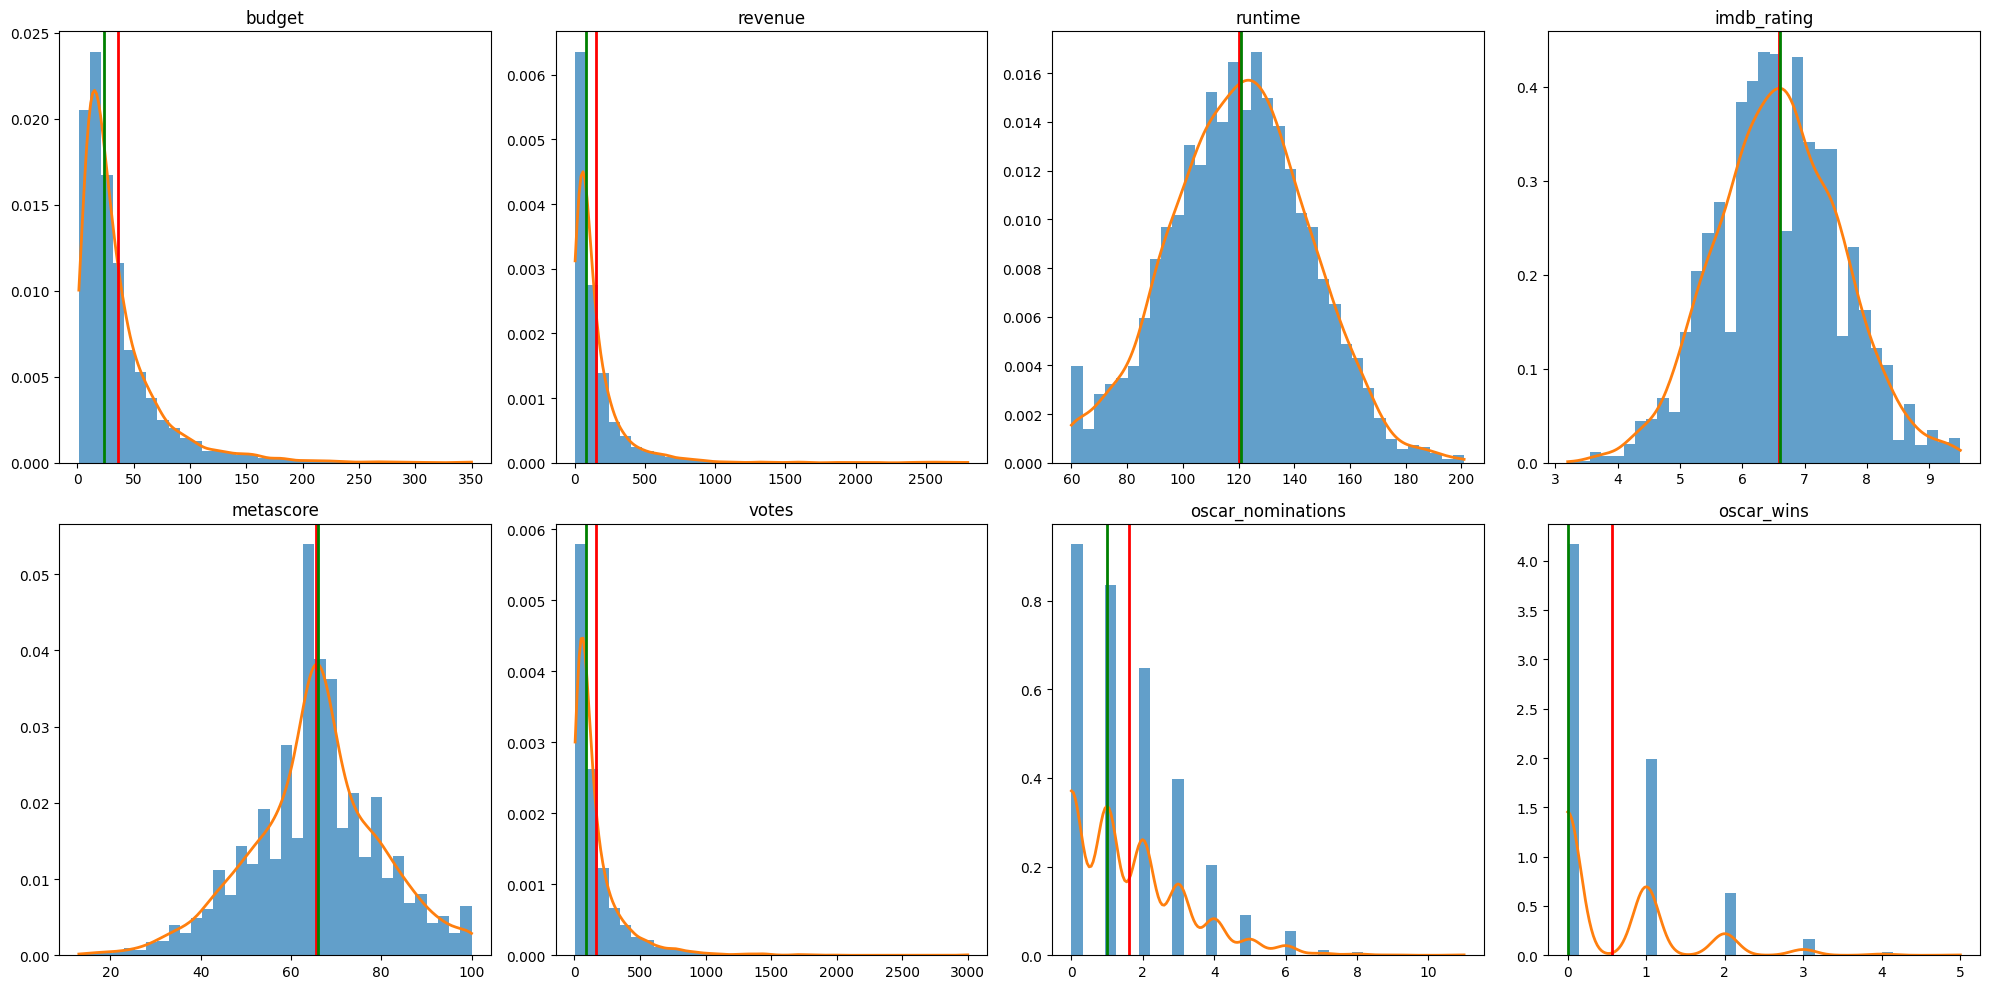


[2] Boxplots showing spread and potential outliers


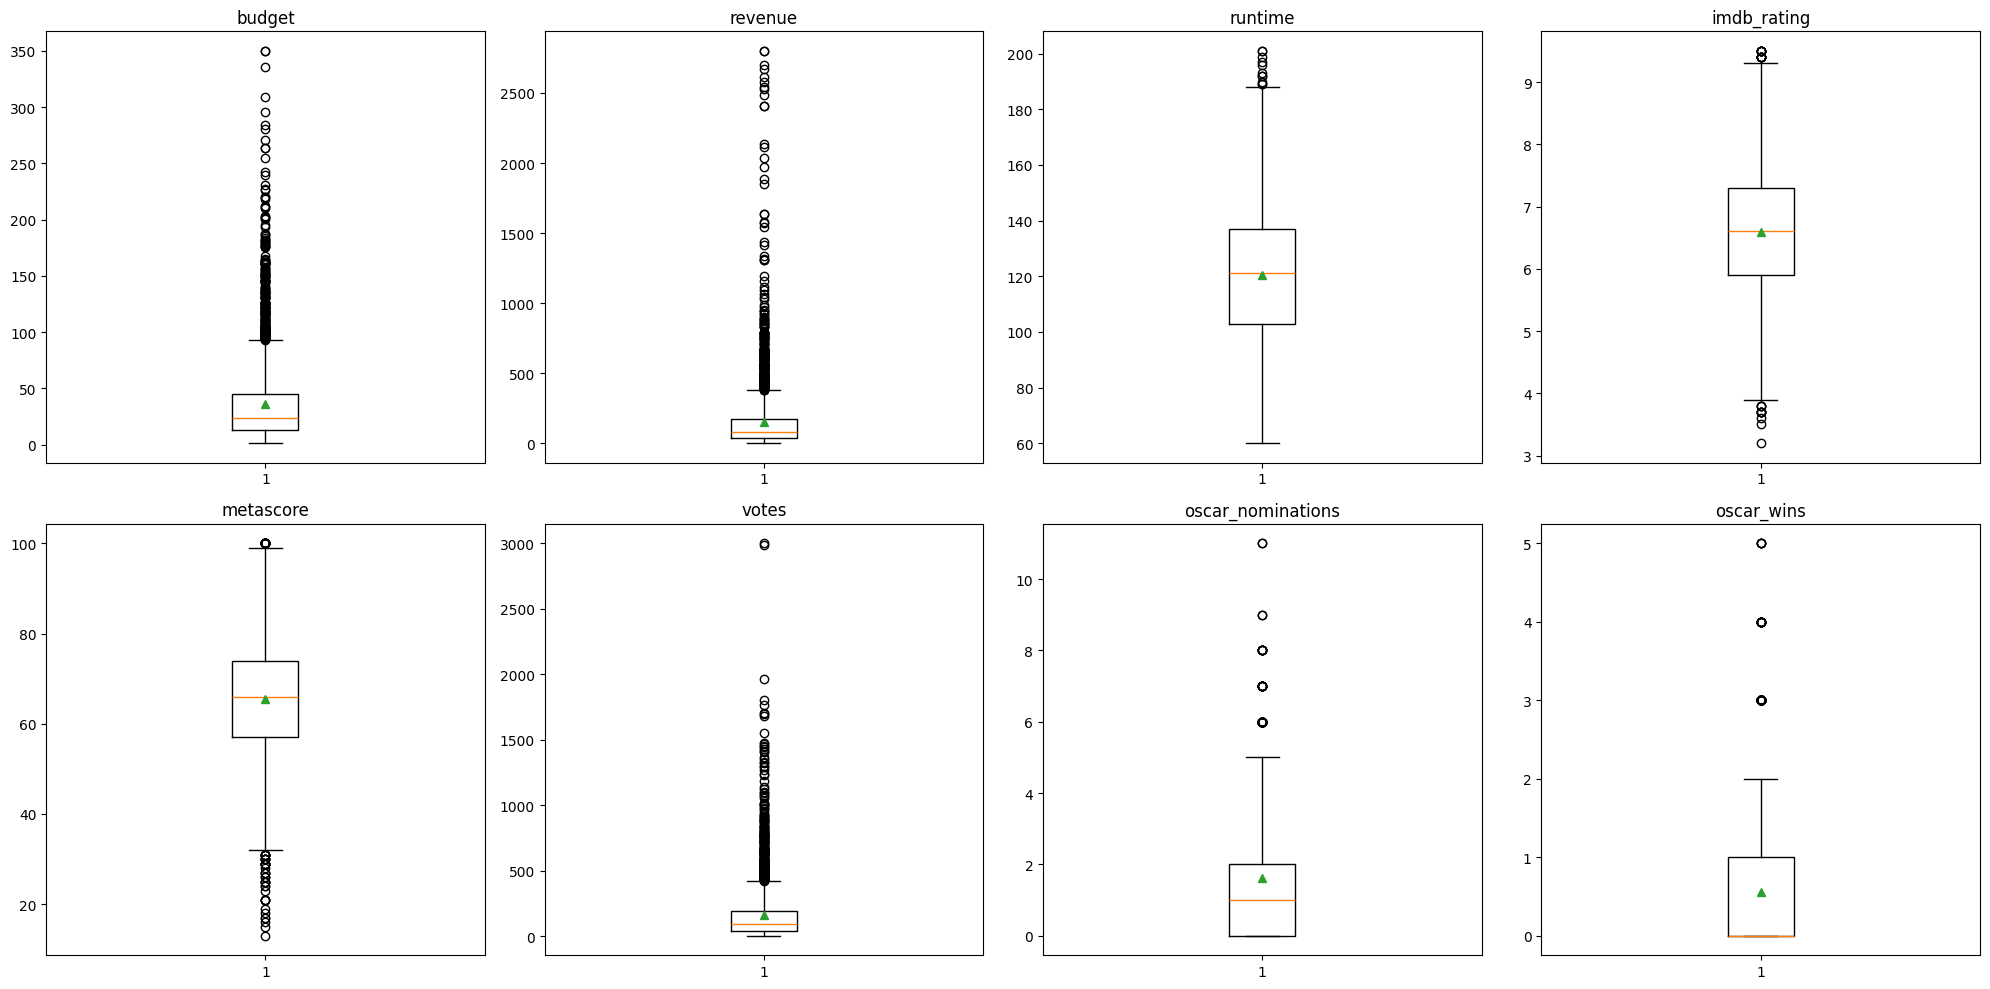


[3] Outlier detection using IQR rule (1.5 × IQR)
budget: lower=-35.1812, upper=93.0687, outliers=209
revenue: lower=-168.7550, upper=381.6850, outliers=245
votes: lower=-186.7875, upper=424.9125, outliers=255

Total outlier movies: 564
Revenue share contributed by outliers (%): 49.872043184552204

Top-5 revenue outlier movies:


,title,release_year,genre,budget,revenue,votes,imdb_rating
2925,Movie 2926,2007,Comedy,295.279999999999973,2800.000000000000000,126.900000000000006,6.000000000000000
1610,Movie 1611,2022,Thriller,284.230000000000018,2800.000000000000000,137.599999999999994,7.200000000000000
1975,Movie 1976,2021,Sci-Fi,209.990000000000009,2702.199999999999818,68.000000000000000,7.000000000000000
1280,Movie 1281,2005,Sci-Fi,242.610000000000014,2670.610000000000127,31.800000000000001,5.000000000000000
326,Movie 327,1992,Comedy,200.330000000000013,2613.960000000000036,49.799999999999997,5.800000000000000



[4] Normality assessment for IMDb rating
Mean rating: 6.591033333333333
Standard deviation: 1.0088585286017393


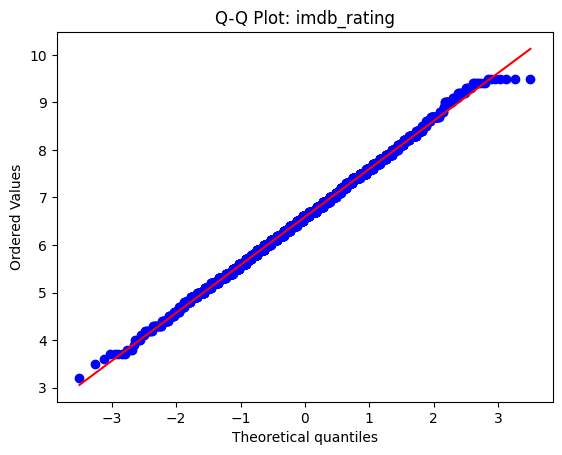

Percentage within 1 SD: 67.73333333333333
Percentage within 2 SD: 95.36666666666666
Percentage within 3 SD: 99.93333333333332


In [14]:
print("\n=== PART 3: DISTRIBUTION ANALYSIS ===")

# --------------------------------------------------
# 1) HISTOGRAMS + KDE + MEAN/MEDIAN LINES
# --------------------------------------------------
print("\n[1] Distribution plots: histogram + density + mean/median")

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for ax, col in zip(axes, numeric_cols):
    s = dfv[col].dropna()

    # Histogram
    ax.hist(s, bins=35, density=True, alpha=0.7)

    # KDE curve (only if enough unique values)
    if len(s) > 20 and s.nunique() > 5:
        kde = stats.gaussian_kde(s)
        xs = np.linspace(s.min(), s.max(), 200)
        ax.plot(xs, kde(xs), linewidth=2)

    # Mean (red) & Median (green)
    ax.axvline(s.mean(), color="red", linewidth=2, label="mean")
    ax.axvline(s.median(), color="green", linewidth=2, label="median")

    ax.set_title(col)

plt.tight_layout()
plt.show()


# --------------------------------------------------
# 2) BOXPLOTS (OUTLIER VISUALIZATION)
# --------------------------------------------------
print("\n[2] Boxplots showing spread and potential outliers")

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for ax, col in zip(axes, numeric_cols):
    ax.boxplot(dfv[col].dropna(), showmeans=True)
    ax.set_title(col)

plt.tight_layout()
plt.show()


# --------------------------------------------------
# 3) OUTLIER ANALYSIS USING IQR (budget, revenue, votes)
# --------------------------------------------------
print("\n[3] Outlier detection using IQR rule (1.5 × IQR)")

def iqr_bounds(s):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    return q1 - 1.5 * iqr, q3 + 1.5 * iqr

masks = {}
for c in ["budget", "revenue", "votes"]:
    lo, hi = iqr_bounds(dfv[c].dropna())
    masks[c] = (dfv[c] < lo) | (dfv[c] > hi)
    print(f"{c}: lower={lo:.4f}, upper={hi:.4f}, outliers={masks[c].sum()}")

# Combined outlier dataframe
outliers_df = dfv[masks["budget"] | masks["revenue"] | masks["votes"]]
print("\nTotal outlier movies:", len(outliers_df))

# Revenue share from outliers
share = outliers_df["revenue"].sum() / dfv["revenue"].sum() * 100
print("Revenue share contributed by outliers (%):", share)

# Show top 5 extreme movies
print("\nTop-5 revenue outlier movies:")
display(
    outliers_df.sort_values("revenue", ascending=False).head(5)[
        ["title","release_year","genre","budget","revenue","votes","imdb_rating"]
    ]
)


# --------------------------------------------------
# 4) NORMALITY TEST FOR IMDB RATING
# --------------------------------------------------
print("\n[4] Normality assessment for IMDb rating")

r = dfv["imdb_rating"].dropna()
mu, sd = r.mean(), r.std(ddof=1)

print("Mean rating:", mu)
print("Standard deviation:", sd)

# Q-Q plot
stats.probplot(r, dist="norm", plot=plt)
plt.title("Q-Q Plot: imdb_rating")
plt.show()

# 68-95-99.7 rule comparison
for k in [1, 2, 3]:
    pct = ((r - mu).abs() <= k * sd).mean() * 100
    print(f"Percentage within {k} SD:", pct)

## PART 4 — RELATIONSHIPS


=== PART 4: RELATIONSHIP ANALYSIS ===

[1] Correlation matrix between numerical variables


,budget,revenue,runtime,imdb_rating,metascore,votes,oscar_nominations,oscar_wins
budget,1.000000000000000,0.737471114443694,-0.030352454704796,0.008383855791682,0.025814655516995,-0.025310092024388,-0.020613685890330,-0.034691821021359
revenue,0.737471114443694,1.000000000000000,-0.028831536588761,-0.006420740324846,0.012381141827471,-0.023310591409473,-0.020199371837879,-0.021194497869944
runtime,-0.030352454704796,-0.028831536588761,1.000000000000000,-0.012471292187189,-0.013326995428920,-0.014113735568953,-0.011913932637780,-0.021859467961850
imdb_rating,0.008383855791682,-0.006420740324846,-0.012471292187189,1.000000000000000,0.589700409260468,-0.018931989389213,0.592217426120545,0.391925536491113
metascore,0.025814655516995,0.012381141827471,-0.013326995428920,0.589700409260468,1.000000000000000,0.000773410568333,0.343625927657740,0.214585492139982
votes,-0.025310092024388,-0.023310591409473,-0.014113735568953,-0.018931989389213,0.000773410568333,1.000000000000000,-0.007051773918423,-0.002646173323537
oscar_nominations,-0.020613685890330,-0.020199371837879,-0.011913932637780,0.592217426120545,0.343625927657740,-0.007051773918423,1.000000000000000,0.672966427720141
oscar_wins,-0.034691821021359,-0.021194497869944,-0.021859467961850,0.391925536491113,0.214585492139982,-0.002646173323537,0.672966427720141,1.000000000000000



Strong positive correlations (> 0.7):


,var1,var2,corr
0,budget,revenue,0.737471114443694



Strong negative correlations (< -0.3):


,var1,var2,corr



[2] Scatter plot matrix colored by genre


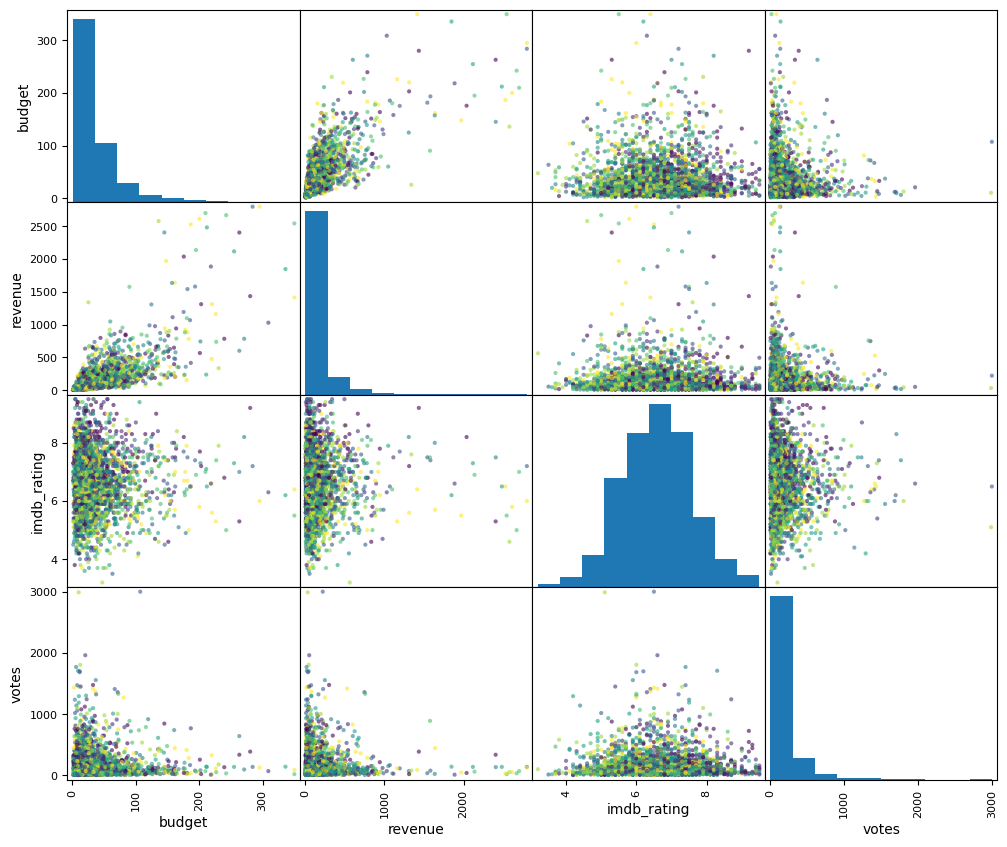


[3] Profit margin and its relationship with IMDb rating
Correlation between profit_margin and imdb_rating: 8.317670411473844e-05


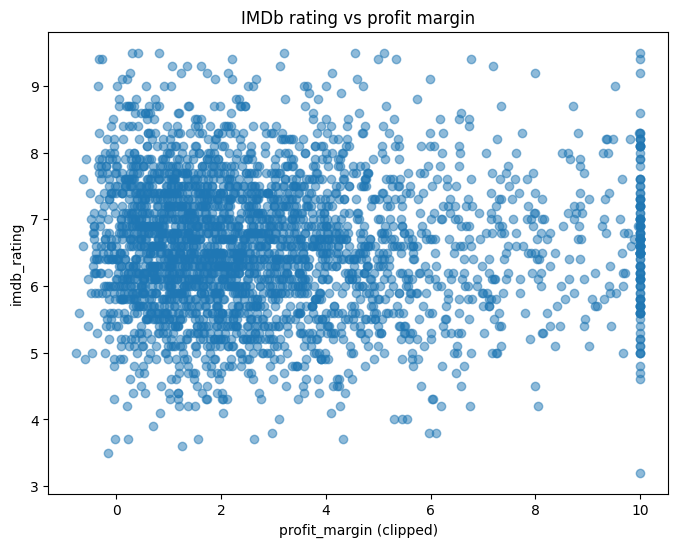

In [15]:
print("\n=== PART 4: RELATIONSHIP ANALYSIS ===")

# --------------------------------------------------
# 1) CORRELATION MATRIX
# --------------------------------------------------
print("\n[1] Correlation matrix between numerical variables")

corr = dfv[numeric_cols].corr()
display(corr)

# Find strong correlations
pairs = []
for i in range(len(numeric_cols)):
    for j in range(i + 1, len(numeric_cols)):
        r = corr.iloc[i, j]
        if pd.notna(r):
            pairs.append((numeric_cols[i], numeric_cols[j], r))

strong_pos = [p for p in pairs if p[2] > 0.7]
strong_neg = [p for p in pairs if p[2] < -0.3]

print("\nStrong positive correlations (> 0.7):")
display(pd.DataFrame(strong_pos, columns=["var1","var2","corr"]))

print("\nStrong negative correlations (< -0.3):")
display(pd.DataFrame(strong_neg, columns=["var1","var2","corr"]))


# --------------------------------------------------
# 2) SCATTER MATRIX (budget, revenue, imdb_rating, votes)
# --------------------------------------------------
print("\n[2] Scatter plot matrix colored by genre")

tmp = dfv[["budget","revenue","imdb_rating","votes","genre"]].dropna()
colors = pd.factorize(tmp["genre"])[0]

pd.plotting.scatter_matrix(
    tmp[["budget","revenue","imdb_rating","votes"]],
    figsize=(12, 10),
    diagonal="hist",
    c=colors,
    alpha=0.6
)
plt.show()


# --------------------------------------------------
# 3) PROFIT MARGIN ANALYSIS
# --------------------------------------------------
print("\n[3] Profit margin and its relationship with IMDb rating")

# Compute profit margin (avoid division by zero)
dfv["profit_margin"] = np.where(
    dfv["budget"] > 0,
    (dfv["revenue"] - dfv["budget"]) / dfv["budget"],
    np.nan
)

pm = dfv[["profit_margin","imdb_rating"]].dropna()

corr_pm = pm["profit_margin"].corr(pm["imdb_rating"])
print("Correlation between profit_margin and imdb_rating:", corr_pm)

# Scatter plot (clipped for visualization)
plt.figure(figsize=(8, 6))
plt.scatter(pm["profit_margin"].clip(-1, 10), pm["imdb_rating"], alpha=0.5)
plt.title("IMDb rating vs profit margin")
plt.xlabel("profit_margin (clipped)")
plt.ylabel("imdb_rating")
plt.show()

## PART 5 — COMPARISONS


=== PART 5: COMPARATIVE ANALYSIS ===

[Task 5.1] Genre comparison


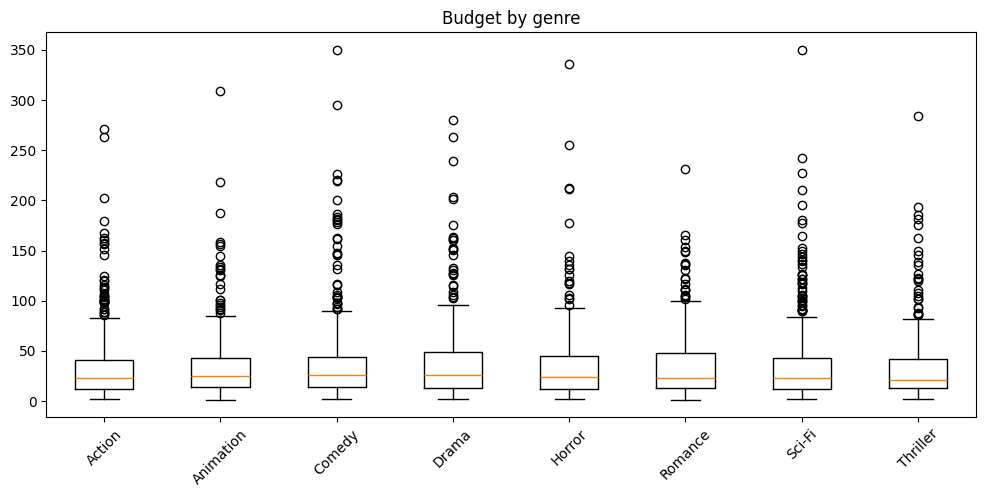

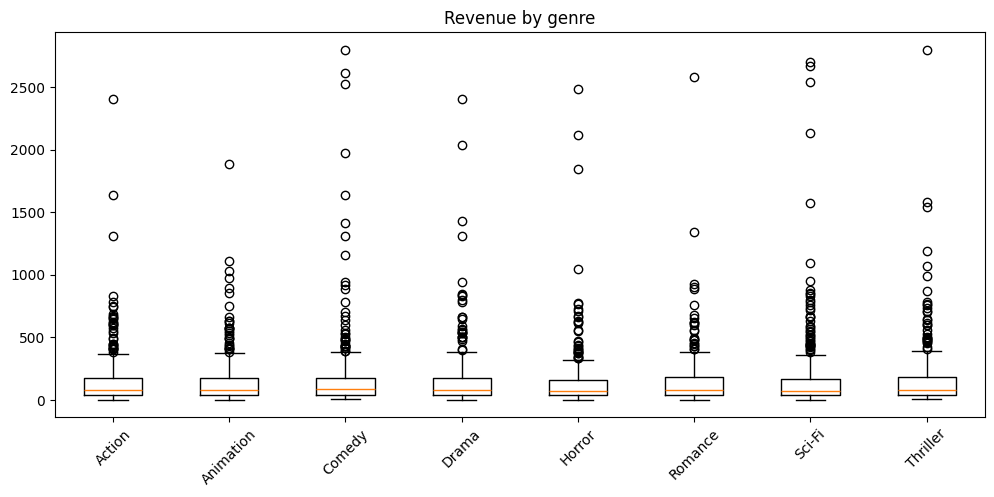

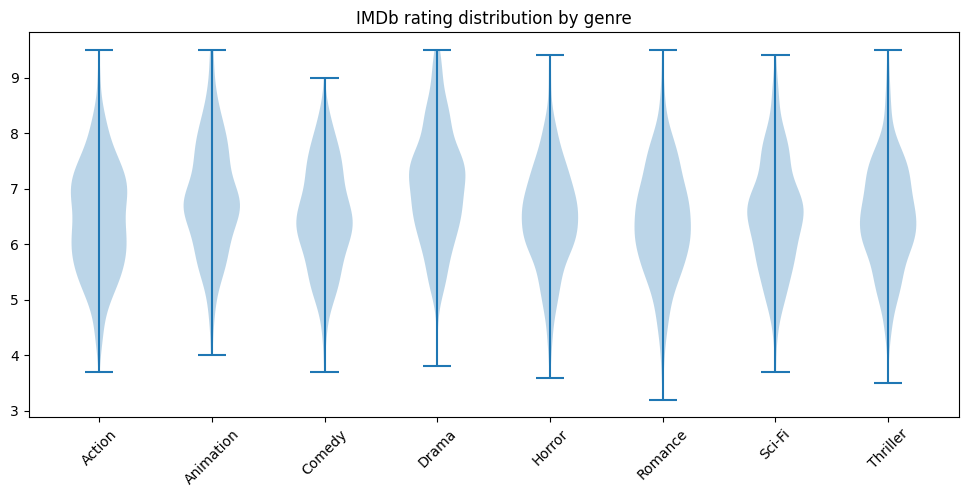


Average profit margin by genre:


genre
Action      3.403967947206933
Thriller    3.392470523900831
Comedy      3.236549134593981
Romance     3.230573814676347
Animation   3.169065079874553
Sci-Fi      3.048292547657505
Horror      2.989371367781270
Drama       2.942004357463690
Name: profit_margin, dtype: float64


Total Oscar wins by genre:


genre
Drama        262
Comedy       228
Animation    226
Horror       211
Sci-Fi       198
Action       196
Thriller     190
Romance      177
Name: oscar_wins, dtype: int64


[ANSWERS — Task 5.1]
Genre with highest median budget: Comedy
Genre with most consistent ratings (lowest SD): Comedy
Genre with highest average profit margin: Action

[Task 5.2] Time trend analysis


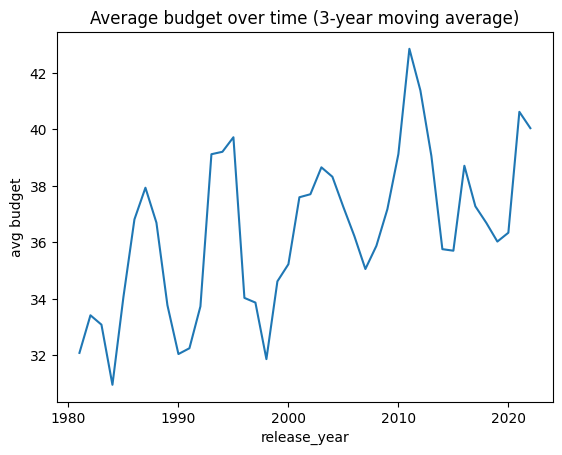

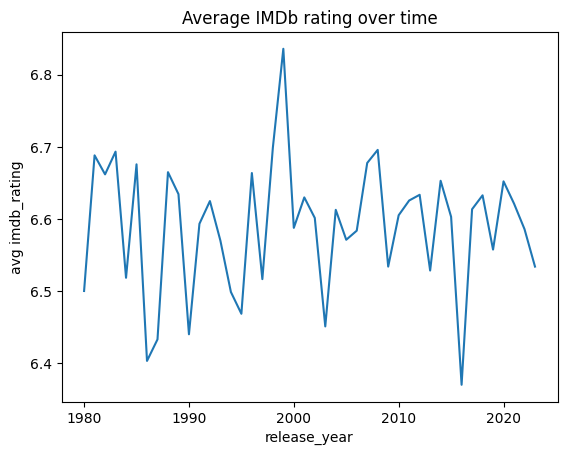


[ANSWERS — Task 5.2]
Early period mean rating: 6.588270230141055
Late period mean rating: 6.5932849364791295
Welch t-test p-value: 0.8922563157022714
Conclusion: No statistically significant change in movie quality over time.

[Task 5.3] Director analysis

Top-10 directors statistics:


,movies,avg_imdb,avg_profit,avg_oscar_nom
director,,,,
Patty Jenkins,320,6.556562500000000,3.307614031260365,1.559375000000000
Steven Spielberg,308,6.629220779220779,3.306000106426084,1.678571428571429
Denis Villeneuve,306,6.512091503267974,3.072892216283831,1.516339869281046
Martin Scorsese,303,6.505280528052805,3.066143510436214,1.600660066006601
Quentin Tarantino,303,6.599669966996700,3.306999299861572,1.600660066006601
James Cameron,297,6.565319865319865,3.323415521514751,1.390572390572391
Christopher Nolan,295,6.645762711864407,3.091015128140752,1.705084745762712
Greta Gerwig,292,6.673287671232877,3.023386770985819,1.616438356164384
Ridley Scott,292,6.622602739726028,2.996799337764605,1.660958904109589


In [ ]:
print("\n=== PART 5: COMPARATIVE ANALYSIS ===")

# --------------------------------------------------
# TASK 5.1 — GENRE COMPARISON
# --------------------------------------------------
print("\n[Task 5.1] Genre comparison")

genres = sorted(dfv["genre"].unique())

# --- 1) Budget & Revenue boxplots ---
plt.figure(figsize=(12,5))
plt.boxplot([dfv[dfv["genre"]==g]["budget"].dropna() for g in genres])
plt.title("Budget by genre")
plt.xticks(range(1, len(genres) + 1), genres, rotation=45)
plt.show()

plt.figure(figsize=(12,5))
plt.boxplot([dfv[dfv["genre"]==g]["revenue"].dropna() for g in genres])
plt.title("Revenue by genre")
plt.xticks(range(1, len(genres) + 1), genres, rotation=45)
plt.show()

# --- 2) IMDb rating violin plot ---
plt.figure(figsize=(12,5))
plt.violinplot([dfv[dfv["genre"]==g]["imdb_rating"].dropna() for g in genres])
plt.xticks(range(1, len(genres)+1), genres, rotation=45)
plt.title("IMDb rating distribution by genre")
plt.show()

# --- 3) Profitability by genre ---
avg_profit = dfv.groupby("genre")["profit_margin"].mean().sort_values(ascending=False)

print("\nAverage profit margin by genre:")
display(avg_profit)

# --- 4) Total Oscar wins by genre ---
oscar_total = dfv.groupby("genre")["oscar_wins"].sum().sort_values(ascending=False)

print("\nTotal Oscar wins by genre:")
display(oscar_total)


# --- ANSWERS TO QUESTIONS (Task 5.1) ---
median_budget = dfv.groupby("genre")["budget"].median().sort_values(ascending=False)
rating_sd = dfv.groupby("genre")["imdb_rating"].std(ddof=1).sort_values()

print("\n[ANSWERS — Task 5.1]")
print("Genre with highest median budget:", median_budget.index[0])
print("Genre with most consistent ratings (lowest SD):", rating_sd.index[0])
print("Genre with highest average profit margin:", avg_profit.index[0])


# --------------------------------------------------
# TASK 5.2 — TIME TREND ANALYSIS
# --------------------------------------------------
print("\n[Task 5.2] Time trend analysis")

bud = dfv.groupby("release_year")["budget"].mean()
rat = dfv.groupby("release_year")["imdb_rating"].mean()

# Budget trend with 3-year moving average
plt.plot(bud.index, bud.rolling(3, center=True).mean())
plt.title("Average budget over time (3-year moving average)")
plt.xlabel("release_year")
plt.ylabel("avg budget")
plt.show()

# Rating trend
plt.plot(rat.index, rat)
plt.title("Average IMDb rating over time")
plt.xlabel("release_year")
plt.ylabel("avg imdb_rating")
plt.show()

# Statistical comparison: early vs late period
early = dfv[(dfv["release_year"] <= 1999)]["imdb_rating"].dropna()
late  = dfv[(dfv["release_year"] >= 2000)]["imdb_rating"].dropna()

tstat, pval = stats.ttest_ind(early, late, equal_var=False, nan_policy="omit")

print("\n[ANSWERS — Task 5.2]")
print("Early period mean rating:", early.mean())
print("Late period mean rating:", late.mean())
print("Welch t-test p-value:", pval)

if pval < 0.05:
    print("Conclusion: Movie quality has significantly changed over time.")
else:
    print("Conclusion: No statistically significant change in movie quality over time.")


# --------------------------------------------------
# TASK 5.3 — DIRECTOR ANALYSIS
# --------------------------------------------------
print("\n[Task 5.3] Director analysis")

top10 = dfv["director"].value_counts().head(10).index

director_stats = (
    dfv[dfv["director"].isin(top10)]
    .groupby("director")
    .agg(
        movies=("movie_id","count"),
        avg_imdb=("imdb_rating","mean"),
        avg_profit=("profit_margin","mean"),
        avg_oscar_nom=("oscar_nominations","mean")
    )
    .sort_values("movies", ascending=False)
)

print("\nTop-10 directors statistics:")
display(director_stats)